In [1]:
from matplotlib import pyplot
import seaborn

In [2]:
from metrics.utils import constants

data = "fashion-mnist"
metric = "manhattan"
report_dir = constants.DATA_ROOT.joinpath(data, metric)
tree_path = report_dir.joinpath("tree.arrow")
leaves_path = report_dir.joinpath("leaves.arrow")
distances_path = report_dir.joinpath("query-distances-batch-1-1.npy")

In [17]:
import polars

# Columns: ['name', 'depth', 'left', 'right', 'cardinality', 'arg_center', 'arg_radius', 'radius', 'lfd', 'polar_distance']
tree_df = polars.scan_ipc(tree_path)
print(tree_df.columns)
print(tree_df.head().collect())

['name', 'depth', 'left', 'right', 'cardinality', 'arg_center', 'arg_radius', 'radius', 'lfd', 'polar_distance']
shape: (5, 10)
┌──────┬───────┬──────┬───────┬─────┬────────────┬──────────┬──────────┬────────────────┐
│ name ┆ depth ┆ left ┆ right ┆ ... ┆ arg_radius ┆ radius   ┆ lfd      ┆ polar_distance │
│ ---  ┆ ---   ┆ ---  ┆ ---   ┆     ┆ ---        ┆ ---      ┆ ---      ┆ ---            │
│ str  ┆ u64   ┆ str  ┆ str   ┆     ┆ u64        ┆ f32      ┆ f32      ┆ f32            │
╞══════╪═══════╪══════╪═══════╪═════╪════════════╪══════════╪══════════╪════════════════╡
│ 1    ┆ 0     ┆ 2    ┆ 3     ┆ ... ┆ 36212      ┆ 114942.0 ┆ 0.38173  ┆ 143571.0       │
│ 2    ┆ 1     ┆ 4    ┆ 5     ┆ ... ┆ 27444      ┆ 78592.0  ┆ 1.211281 ┆ 110009.0       │
│ 4    ┆ 2     ┆ 8    ┆ 9     ┆ ... ┆ 29012      ┆ 78825.0  ┆ 0.525778 ┆ 114781.0       │
│ 8    ┆ 3     ┆ 10   ┆ 11    ┆ ... ┆ 21598      ┆ 70096.0  ┆ 0.548634 ┆ 96817.0        │
│ 10   ┆ 4     ┆ 20   ┆ 21    ┆ ... ┆ 32684      ┆ 64976.0  ┆ 

In [14]:
selectors = [
    polars.col("radius").quantile(v / 100).alias(f"quantile-{v}")
    for v in range(10, 100, 10)
]

radii: polars.DataFrame = (
    tree_df
    .groupby("depth")
    .agg([
        polars.col("radius").min().alias(f"min"),
        polars.col("radius").quantile(1 / 100).alias(f"quantile-01"),
        *selectors,
        polars.col("radius").quantile(99 / 100).alias(f"quantile-99"),
        polars.col("radius").max().alias(f"max"),
    ])
    .sort("depth")
    .collect()
)
print(radii.head())

shape: (5, 14)
┌───────┬──────────┬───────────┬───────────┬─────┬───────────┬───────────┬──────────────┬──────────┐
│ depth ┆ min      ┆ quantile- ┆ quantile- ┆ ... ┆ quantile- ┆ quantile- ┆ quantile-99  ┆ max      │
│ ---   ┆ ---      ┆ 01        ┆ 10        ┆     ┆ 80        ┆ 90        ┆ ---          ┆ ---      │
│ u64   ┆ f32      ┆ ---       ┆ ---       ┆     ┆ ---       ┆ ---       ┆ f32          ┆ f32      │
│       ┆          ┆ f32       ┆ f32       ┆     ┆ f32       ┆ f32       ┆              ┆          │
╞═══════╪══════════╪═══════════╪═══════════╪═════╪═══════════╪═══════════╪══════════════╪══════════╡
│ 0     ┆ 114942.0 ┆ 114942.0  ┆ 114942.0  ┆ ... ┆ 114942.0  ┆ 114942.0  ┆ 114942.0     ┆ 114942.0 │
│ 1     ┆ 78592.0  ┆ 78592.0   ┆ 78592.0   ┆ ... ┆ 105152.0  ┆ 105152.0  ┆ 105152.0     ┆ 105152.0 │
│ 2     ┆ 76667.0  ┆ 76667.0   ┆ 76667.0   ┆ ... ┆ 84023.0   ┆ 84023.0   ┆ 84023.0      ┆ 84023.0  │
│ 3     ┆ 67879.0  ┆ 67879.0   ┆ 67879.0   ┆ ... ┆ 76291.0   ┆ 76583.0   ┆ 7

In [18]:
radii.columns

,min,quantile-01,quantile-10,quantile-20,quantile-30,quantile-40,quantile-50,quantile-60,quantile-70,quantile-80,quantile-90,quantile-99,max
0,114942.0,114942.0,114942.0,114942.0,114942.0,114942.0,114942.0,114942.0,114942.0,114942.0,114942.0,114942.0,114942.0
1,78592.0,78592.0,78592.0,78592.0,78592.0,78592.0,105152.0,105152.0,105152.0,105152.0,105152.0,105152.0,105152.0
2,76667.0,76667.0,76667.0,76667.0,76783.0,76783.0,78825.0,78825.0,78825.0,84023.0,84023.0,84023.0,84023.0
3,67879.0,67879.0,67879.0,68024.0,69249.0,69612.0,70096.0,70096.0,70445.0,76291.0,76583.0,76583.0,76583.0
4,60161.0,60161.0,60700.0,63261.0,64976.0,65172.0,65682.0,65791.0,71260.0,72465.0,76179.0,76394.0,76394.0


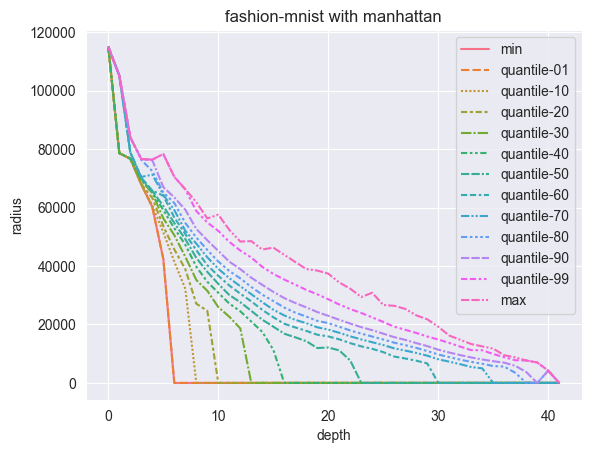

In [19]:
import pandas

radii_pd: pandas.DataFrame = radii.to_pandas()
radii_pd.set_index("depth")
radii_pd.drop("depth", inplace=True, axis=1)
radii_pd.head()

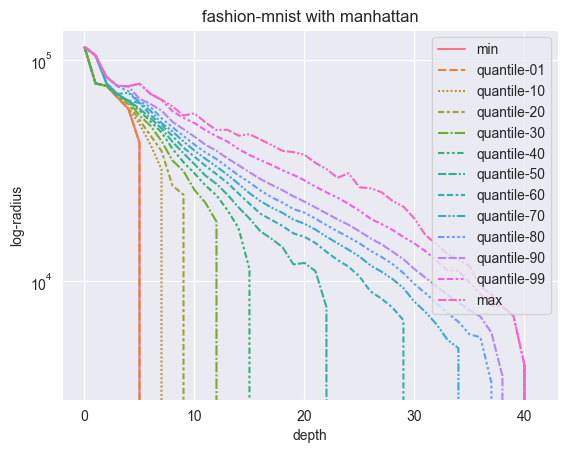

In [20]:
%matplotlib inline

ax = seaborn.lineplot(radii_pd)
ax.set_xlabel("depth")
ax.set_ylabel("radius")
ax.set_title(f"{data} with {metric}")
pyplot.savefig(constants.FIGURES_ROOT.joinpath(f"{data}-{metric}-radius-vs-depth.png"), dpi=300)